In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, losses, metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [ ]:
!unzip drive/MyDrive/Colab\ Notebooks/ROBOTICS/project-jetbot/dataset-final.zip

Archive:  drive/MyDrive/Colab Notebooks/ROBOTICS/project-jetbot/dataset-final.zip
replace dataset/the-cones/0266.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from pathlib import Path
import pandas as pd
import cv2
import numpy as np

X = []
y = []

DS = Path("dataset")
FRAMES_TO_STACK = 5
FINAL_HEIGHT = 180 # crop 25% from the top of the image

recordings = sorted(DS.glob("*.csv"))
for recording in recordings:
    csvfile = Path(recording).name
    print("Loading: ", csvfile)
    df = pd.read_csv(DS / csvfile, header=None)
    y.append(df[[1, 2]].to_numpy())
    recordid = csvfile[:-4]
    img_files = sorted((DS / recordid).glob("*.jpg"))
    images = []
    for filename in img_files:
        file = cv2.imread(str(filename))
        images.append(file)

    # duplicate first image (to be included in first frame stack)
    for i in range(FRAMES_TO_STACK - 1):
        images.insert(0, images[0])

    for i in range(FRAMES_TO_STACK - 1, len(images)):
        framestack = []
        for j in range(FRAMES_TO_STACK):
            img = images[i - FRAMES_TO_STACK + 1 + j]
            img = img[-FINAL_HEIGHT:,:,:]
            framestack.append(img)
        X.append(np.stack(framestack, axis=0))

X = np.array(X)
y = np.concatenate(y)

Loading:  376_1.csv
Loading:  456_1.csv
Loading:  456_2.csv
Loading:  493_1.csv
Loading:  493_2.csv
Loading:  493_3.csv
Loading:  good_turns.csv
Loading:  good_turns_bog.csv
Loading:  long.csv
Loading:  long_turns.csv
Loading:  nice_race.csv
Loading:  our_fast.csv
Loading:  our_fast_short.csv
Loading:  our_good_driving.csv
Loading:  the-cones.csv
Loading:  the-red-kettle.csv
Loading:  the-short.csv
Loading:  the-speedy-cones.csv
Loading:  turn_left.csv
Loading:  zip_skipper.csv


In [ ]:
y.shape

(8734, 2)

In [ ]:
X.shape

(8734, 5, 180, 224, 3)

In [ ]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=50)

BATCH_SIZE = 16
TRAIN_SIZE = int(0.66 * len(dataset))

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)


def apply_brightness_contrast(stack):
    # Generate random brightness and contrast values
    brightness = tf.random.uniform([], -0.3, 0.3)
    contrast = tf.random.uniform([], 0.8, 1.2)

    def transform_frame(frame):
        frame = tf.image.adjust_brightness(frame, brightness)
        frame = tf.image.adjust_contrast(frame, contrast)
        return frame

    # Apply the transformation to each frame in the stack
    stack = tf.map_fn(transform_frame, stack)
    return stack

def mirror(framestack, target):
    to_mirror = tf.random.uniform([]) < 0.5  # only mirror 50% of times

    def mirror_frame(frame):
        return tf.image.flip_left_right(frame)

    framestack = tf.cond(to_mirror, lambda: tf.map_fn(mirror_frame, framestack), lambda: framestack)

    # Adjust the target value if mirroring is applied
    target = tf.cond(to_mirror, lambda: tf.stack([target[0], -target[1]]), lambda: target)

    return framestack, target


def augment(framestack, target):
    framestack = apply_brightness_contrast(framestack)
    framestack, target = mirror(framestack, target)
    return framestack, target

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
import keras

base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=X.shape[2:])
base_model = models.Model(inputs=base_model.input, outputs=base_model.get_layer('conv2_block3_out').output)
base_model.trainable = False

base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 186, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 90, 112, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 90, 112, 64)          256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
inputs = tf.keras.Input(shape=X.shape[1:])

x = layers.TimeDistributed(layers.Lambda(keras.applications.resnet.preprocess_input))(inputs)
x = layers.TimeDistributed(base_model)(x)
x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='tanh')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 180, 224, 3)   0         
                             ]                                   
                                                                 
 time_distributed_15 (TimeD  (None, 5, 180, 224, 3)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 5, 45, 56, 256)    229760    
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 5, 256)            0         
 istributed)                                                     
                                                                 
 dense_14 (Dense)            (None, 5, 64)             1644

In [ ]:
model.compile(optimizer='adam',
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError(),
                       metrics.RootMeanSquaredError()])

checkpoint_cb = ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=10, min_lr=0.00001, verbose=1)

In [ ]:
history = model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])

Epoch 1/1000
361/361 [==============================] - 9s 24ms/step - loss: 0.1770 - mean_absolute_error: 0.2990 - root_mean_squared_error: 0.4207 - val_loss: 0.1827 - val_mean_absolute_error: 0.2988 - val_root_mean_squared_error: 0.4274 - lr: 0.0010
Epoch 2/1000
361/361 [==============================] - 9s 24ms/step - loss: 0.1760 - mean_absolute_error: 0.2964 - root_mean_squared_error: 0.4195 - val_loss: 0.1826 - val_mean_absolute_error: 0.2938 - val_root_mean_squared_error: 0.4273 - lr: 0.0010
Epoch 3/1000
361/361 [==============================] - 9s 24ms/step - loss: 0.1771 - mean_absolute_error: 0.2974 - root_mean_squared_error: 0.4208 - val_loss: 0.1776 - val_mean_absolute_error: 0.2860 - val_root_mean_squared_error: 0.4214 - lr: 0.0010
Epoch 4/1000
361/361 [==============================] - 9s 24ms/step - loss: 0.1746 - mean_absolute_error: 0.2958 - root_mean_squared_error: 0.4179 - val_loss: 0.1691 - val_mean_absolute_error: 0.2808 - val_root_mean_squared_error: 0.4113 - lr:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 9s 24ms/step - loss: 0.1740 - mean_absolute_error: 0.2942 - root_mean_squared_error: 0.4171 - val_loss: 0.1807 - val_mean_absolute_error: 0.2906 - val_root_mean_squared_error: 0.4251 - lr: 0.0010
Epoch 6/1000
361/361 [==============================] - 9s 24ms/step - loss: 0.1743 - mean_absolute_error: 0.2949 - root_mean_squared_error: 0.4175 - val_loss: 0.1711 - val_mean_absolute_error: 0.2801 - val_root_mean_squared_error: 0.4136 - lr: 0.0010
Epoch 7/1000
361/361 [==============================] - 9s 24ms/step - loss: 0.1751 - mean_absolute_error: 0.2947 - root_mean_squared_error: 0.4185 - val_loss: 0.1815 - val_mean_absolute_error: 0.2919 - val_root_mean_squared_error: 0.4261 - lr: 0.0010
Epoch 8/1000
361/361 [==============================] - 9s 24ms/step - loss: 0.1738 - mean_absolute_error: 0.2941 - root_mean_squared_error: 0.4168 - val_loss: 0.1700 - val_mean_absolute_error: 0.2769 - val_root_mean_squared_error: 0.4123 - lr: 0.0010
Epoch

KeyboardInterrupt: 

In [ ]:
base_model.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError(),
                       metrics.RootMeanSquaredError()])

history = model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/1000
361/361 [==============================] - 33s 69ms/step - loss: 0.2334 - mean_absolute_error: 0.2930 - root_mean_squared_error: 0.4831 - val_loss: 0.2256 - val_mean_absolute_error: 0.2853 - val_root_mean_squared_error: 0.4749
Epoch 2/1000
361/361 [==============================] - 24s 67ms/step - loss: 0.2332 - mean_absolute_error: 0.2928 - root_mean_squared_error: 0.4829 - val_loss: 0.2251 - val_mean_absolute_error: 0.2847 - val_root_mean_squared_error: 0.4745
Epoch 3/1000
361/361 [==============================] - 24s 67ms/step - loss: 0.2331 - mean_absolute_error: 0.2927 - root_mean_squared_error: 0.4828 - val_loss: 0.2253 - val_mean_absolute_error: 0.2847 - val_root_mean_squared_error: 0.4746
Epoch 4/1000
361/361 [==============================] - 24s 67ms/step - loss: 0.2333 - mean_absolute_error: 0.2928 - root_mean_squared_error: 0.4830 - val_loss: 0.2255 - val_mean_absolute_error: 0.2848 - val_root_mean_squared_error: 0.4749
Epoch 5/1000
361/361 [==================

KeyboardInterrupt: 

In [ ]:
!pip install tf2onnx

In [ ]:
import tf2onnx
import onnx

MODEL_NAME = 'frame_stack_resnet50'
MODEL_PATH = 'drive/MyDrive/Colab Notebooks/ROBOTICS/project-jetbot' + MODEL_NAME + '.onnx'

onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, MODEL_PATH)

# spec = (tf.TensorSpec((None, FRAMES_TO_STACK, FINAL_HEIGHT, 224, 3), tf.float32, name="input"),)
# model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=MODEL_PATH)

In [ ]:
iterator = iter(val_dataset)

In [ ]:
imgs, y = next(iterator)
preds = model.predict(imgs)

1/1 [==============================] - 0s 39ms/step


In [ ]:
print(y)

tf.Tensor(
[[ 0.71875   -1.       ]
 [ 0.7421875 -1.       ]
 [ 0.6796875  0.       ]
 [ 0.7265625 -1.       ]
 [ 0.7421875  0.       ]
 [ 0.71875   -1.       ]
 [ 0.7421875  0.       ]
 [ 0.7421875 -1.       ]
 [ 0.65625   -1.       ]
 [ 0.7421875  0.       ]
 [ 0.6796875  0.       ]
 [ 0.6796875  0.       ]
 [ 0.6796875  0.9921875]
 [ 0.734375  -1.       ]
 [ 0.7421875 -1.       ]
 [ 0.6796875  0.9921875]], shape=(16, 2), dtype=float64)


In [ ]:
print(np.round(preds, 2))

[[ 0.86 -0.01]
 [ 0.87 -0.47]
 [ 0.87 -0.42]
 [ 0.86 -0.31]
 [ 0.86 -0.37]
 [ 0.86 -0.17]
 [ 0.86 -0.21]
 [ 0.87 -0.4 ]
 [ 0.86 -0.45]
 [ 0.87 -0.42]
 [ 0.86  0.33]
 [ 0.85  0.41]
 [ 0.86  0.07]
 [ 0.87 -0.51]
 [ 0.86 -0.43]
 [ 0.86  0.07]]


In [ ]:
def imshow_framestack(stack):
  fig,axs = plt.subplots(1, 5)
  for i in range(5):
    axs[i].imshow(stack[i])
  plt.plot()

tf.Tensor([ 0.71875 -1.     ], shape=(2,), dtype=float64)
[ 0.86095965 -0.00587708]


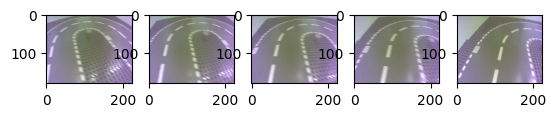

In [ ]:
imshow_framestack(imgs[0])
print(y[0])
print(preds[0])

tf.Tensor([ 0.7421875 -1.       ], shape=(2,), dtype=float64)
[ 0.8654668  -0.46948758]


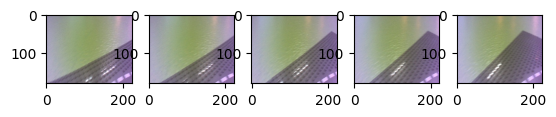

In [ ]:
imshow_framestack(imgs[1])
print(y[1])
print(preds[1])

tf.Tensor([0.6796875 0.       ], shape=(2,), dtype=float64)
[0.8559373  0.33170342]


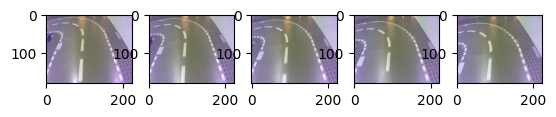

In [ ]:
imshow_framestack(imgs[10])
print(y[10])
print(preds[10])

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.734375, -1.      ])>

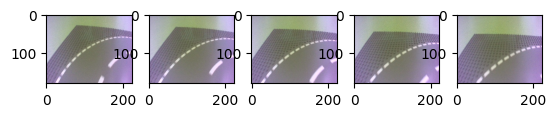

In [ ]:
imshow_framestack(imgs[13])
y[13]

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.7421875, -1.       ])>

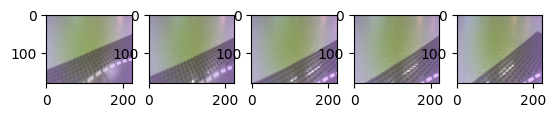

In [ ]:
imshow_framestack(imgs[14])
y[14]

In [ ]:
imgs, y = next(iterator)
print(y)

tf.Tensor(
[[ 0.6796875  0.9921875]
 [ 0.7421875  0.       ]
 [ 0.453125  -0.203125 ]
 [ 0.7421875  0.       ]
 [ 0.7421875 -1.       ]
 [ 0.7734375  0.       ]
 [ 0.71875   -0.34375  ]
 [ 0.6796875  0.9921875]
 [ 0.7265625  0.       ]
 [ 0.6796875  0.       ]
 [ 0.         0.       ]
 [ 0.7421875  0.       ]
 [ 0.7421875  0.       ]
 [ 0.7421875  0.9921875]
 [ 0.7421875  0.       ]
 [ 0.7421875 -0.703125 ]], shape=(16, 2), dtype=float64)


<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.7421875, 0.       ])>

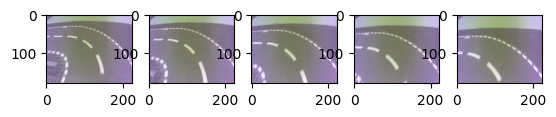

In [ ]:
imshow_framestack(imgs[12])
y[12]

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.7265625, 0.       ])>

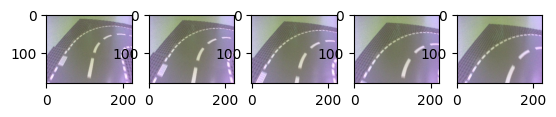

In [ ]:
imshow_framestack(imgs[8])
y[8]